In [1]:
import sys, os
sys.path.append(os.environ['minotaur'])

import datetime
import seaborn; seaborn.set()
import sklearn

import yaml

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm

from pylab import rcParams
rcParams['figure.figsize'] = 14,3
rcParams['font.family'] = 'Open Sans'

from dbs import redshift
redshift.connect()

from __future__ import division

from sklearn.linear_model import SGDRegressor, LinearRegression

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#sets Min and Max and setting to 0 and 1
#preprocessing with polynomial feature generator. don't go more than 2nd order
#PolynomialFeatureGenerator
scaler = MinMaxScaler()
X = pd.read_csv('final.csv',header=0,index_col=0).copy()
X = scaler.fit_transform(X)
y = X['is_won'].copy()
del X['is_won']




In [3]:
sgd = SGDRegressor(n_iter=1000)
sgdfit = sgd.fit(X,y)
y_pred = sgdfit.predict(X)
y_pred[:10]

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=1000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [4]:
sgd = sgd.fit(X,y)
y_pred = sgd.predict(X)
y_pred[:10]

array([ 0.26326826,  0.26326826,  0.299318  ,  0.17201801,  0.38141019,
        0.38466782,  0.23158926,  0.17594838,  0.17080362,  0.18957194])

In [5]:
#calculate statistics on below 
# this is where error lies, further y is from y_pred. look into calculating error
# abs(y_pred - y).mean()

# calculating maximum absolute difference
# mean abs dif is .32 and max is 1.24. on average we are 30% away from the truth
# this is quite a bad model. need to train. a good model is closer to .1 std. 60% of answer will be in 40% of correct answer
# cross validation score. going to matter to us the most. its going to tell us whether there was a stasitcally sig differenece between email, call
np.std(y_pred - y)

0.41440679090097449

In [6]:
mse = sklearn.metrics.mean_squared_error(y, y_pred)
print(mse)


0.172021307058


In [7]:
print(sgd.coef_)
print(sgd.intercept_)
#coef for each additional email it would increase the likihood of the sales by .08%. This is what the model is saying not necessarily the truth. need to get accuracy up
#intercept with no actions at all there is .17%. any change will move the dial .17%

[-0.00893864 -0.00786233  0.02381668 -0.00264498  0.00093601]
[ 0.17586388]


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


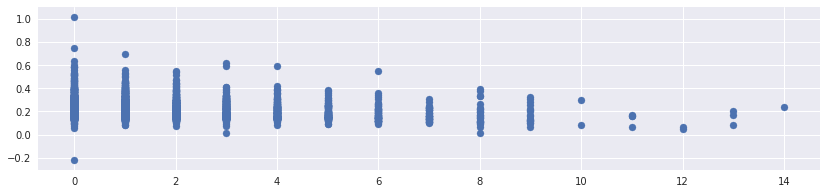

In [8]:
plt.scatter(X.call,y_pred)

###  Validate the Model

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


((5000, 5), (1667, 5))

In [10]:
sgdtrain = sgd.fit(X_train,y_train)
y_predtrain = sgdtrain.predict(X_test)
y_predtrain[:10]

array([ 0.16637761,  0.21003926,  0.16815043,  0.20512691,  0.24210338,
        0.64795915,  0.19620043,  0.20512691,  0.25888835,  0.43231388])

In [11]:
print(sgdtrain.coef_)
print(sgdtrain.intercept_)

[-0.00491236 -0.01159753  0.03206412 -0.00112065  0.02052242]
[ 0.17797514]


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


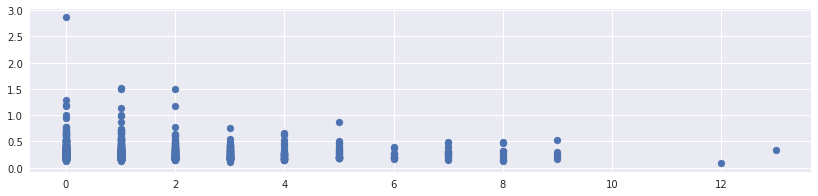

In [12]:
plt.scatter(X_test.call,y_predtrain)

###  Cross Validate the Model

In [13]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((3333, 5), (3334, 5))

In [14]:
# a good score is close to 1
print(SGDRegressor(n_iter=1000).fit(X2, y2).score(X1, y1))
print(SGDRegressor(n_iter=1000).fit(X1, y1).score(X2, y2))

0.0369665293926
0.0372015441084


In [15]:

# a good score is close to 1
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(SGDRegressor(n_iter=1000), X, y, cv=10)
cv.mean()

-0.030369401394391194